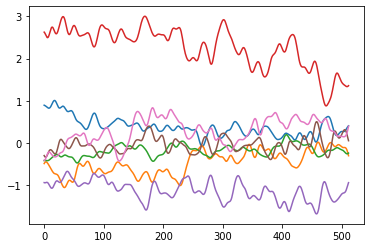

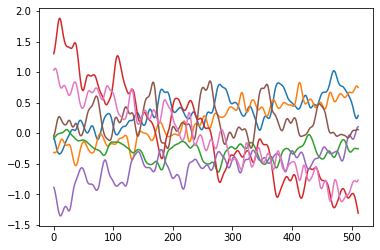

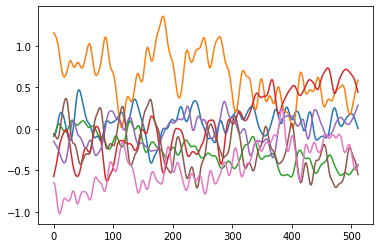

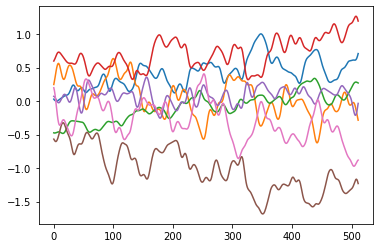

subject 1 is preprocessed


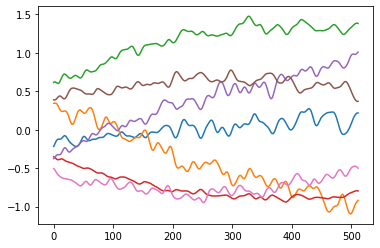

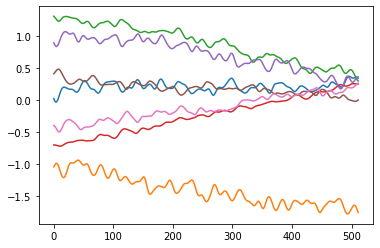

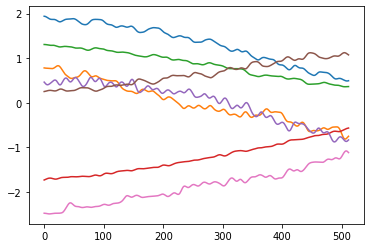

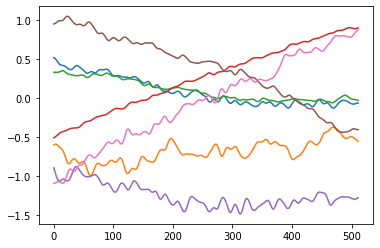

subject 2 is preprocessed


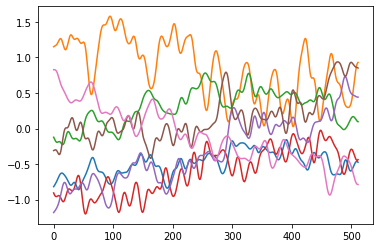

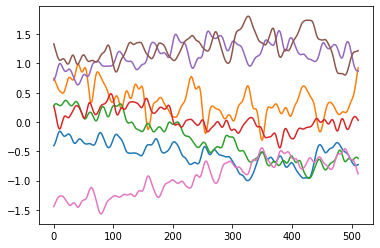

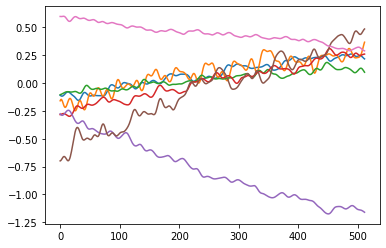

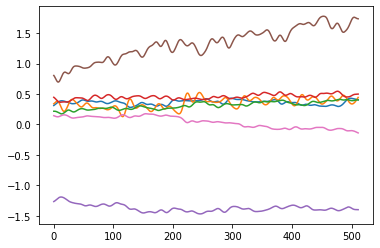

subject 3 is preprocessed


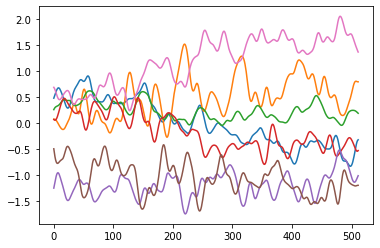

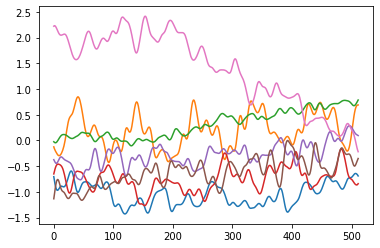

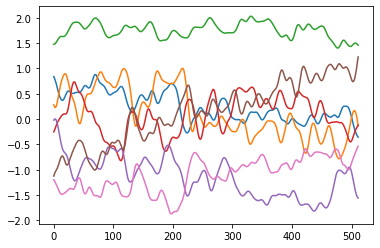

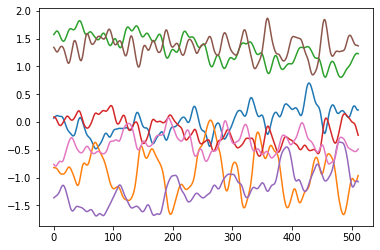

subject 4 is preprocessed


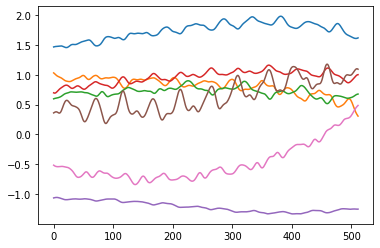

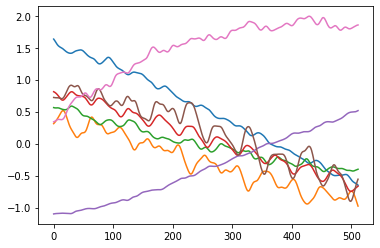

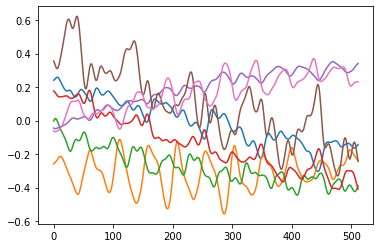

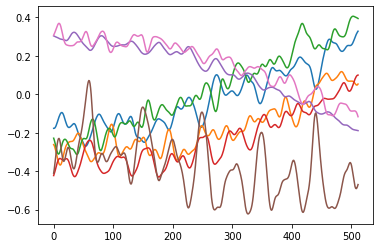

subject 5 is preprocessed


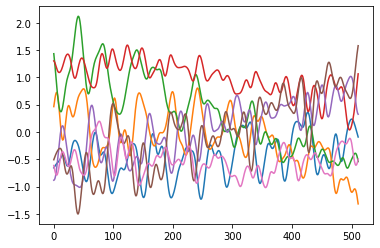

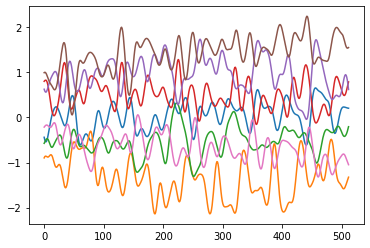

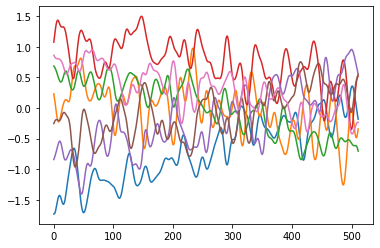

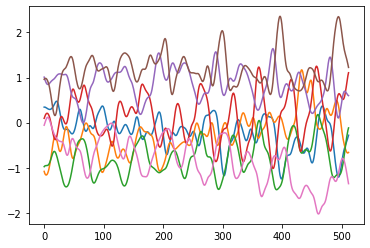

subject 6 is preprocessed


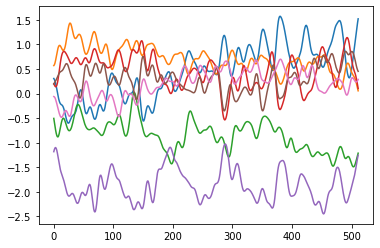

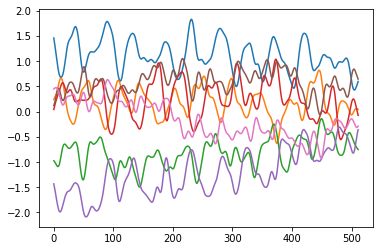

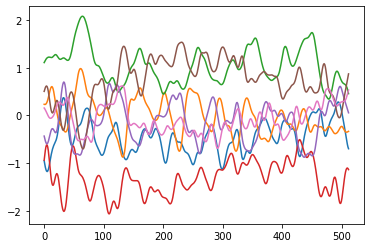

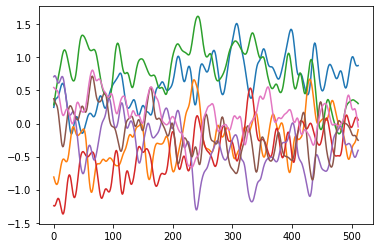

subject 7 is preprocessed


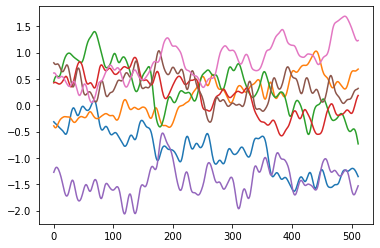

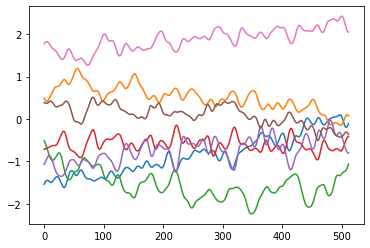

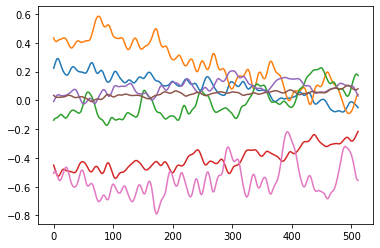

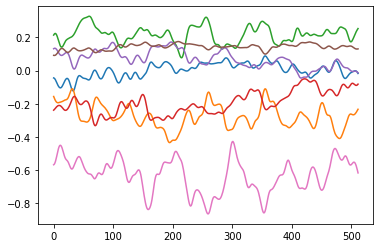

subject 8 is preprocessed


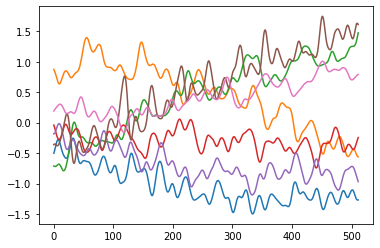

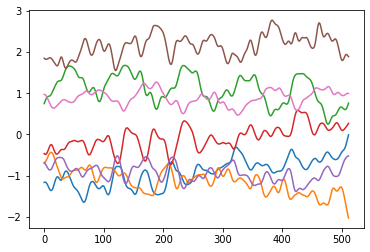

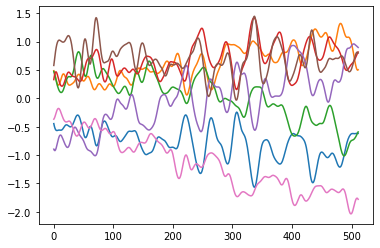

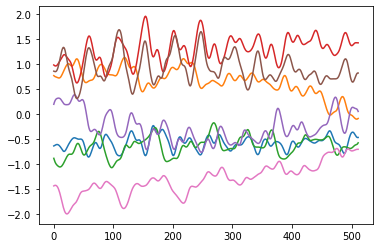

subject 9 is preprocessed


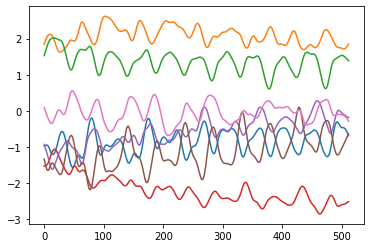

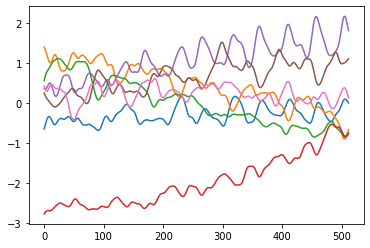

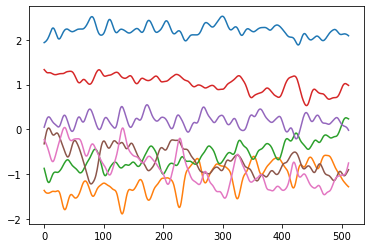

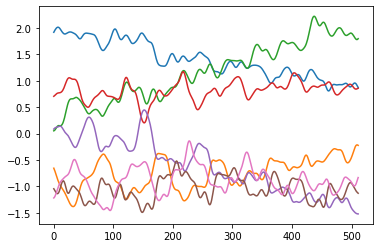

subject 10 is preprocessed


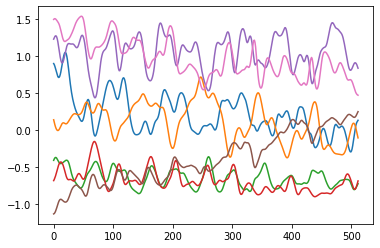

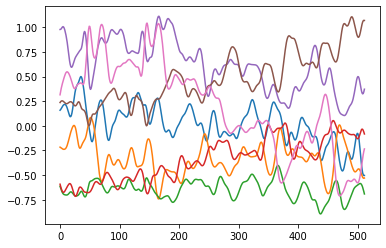

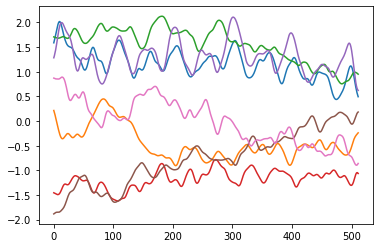

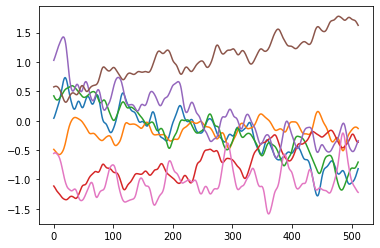

subject 11 is preprocessed


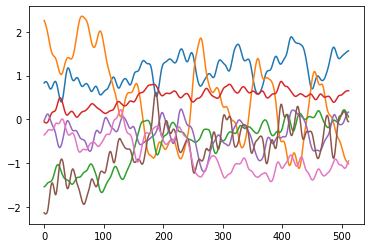

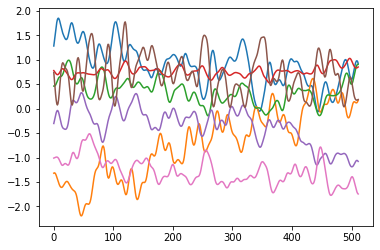

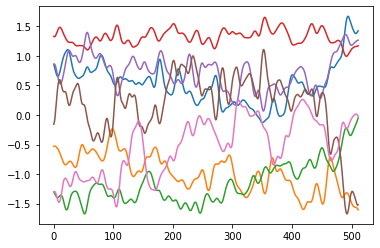

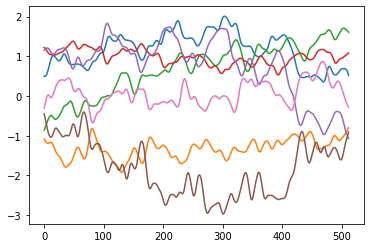

subject 12 is preprocessed


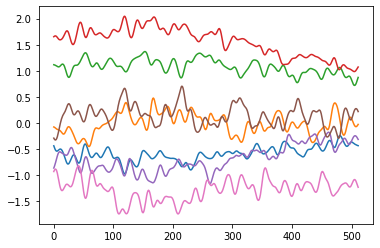

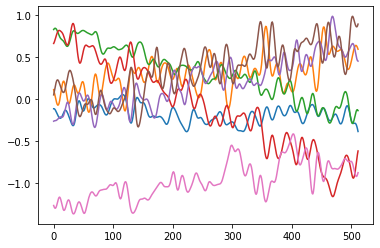

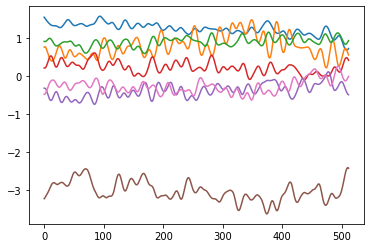

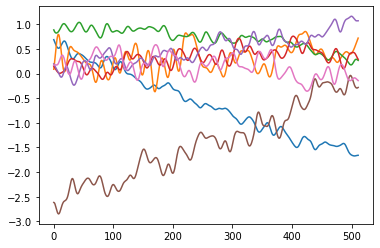

subject 13 is preprocessed


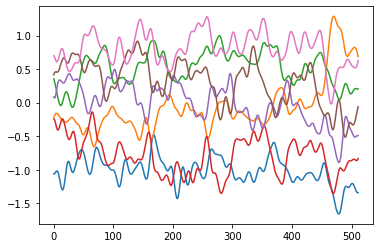

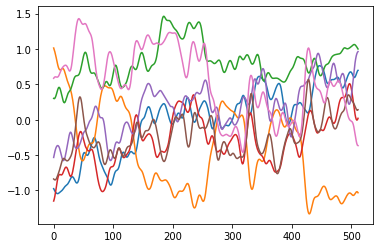

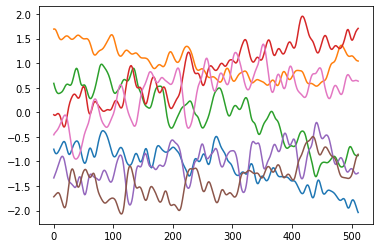

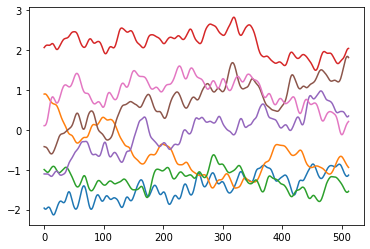

subject 14 is preprocessed


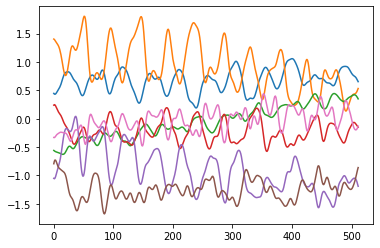

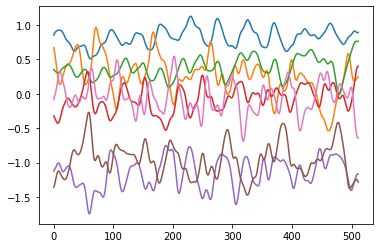

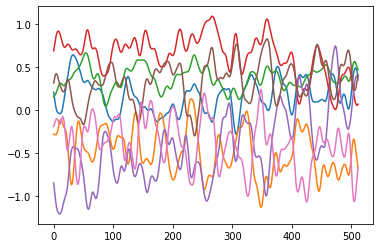

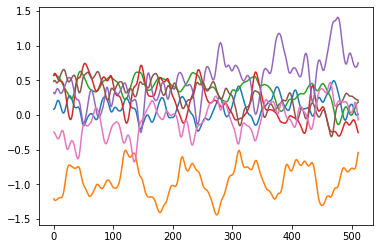

subject 15 is preprocessed


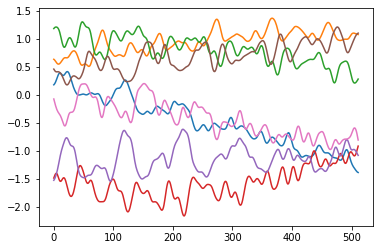

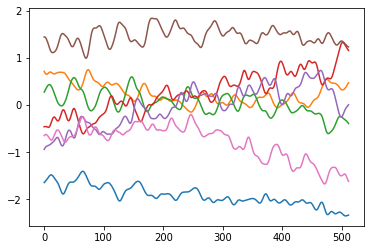

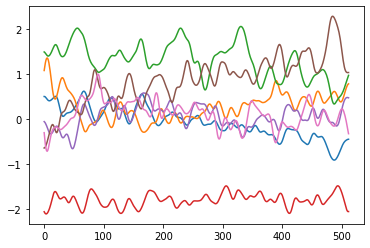

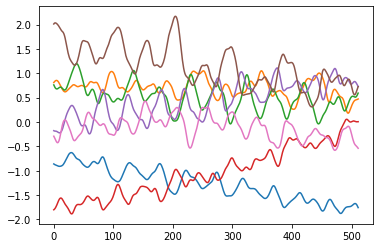

subject 16 is preprocessed


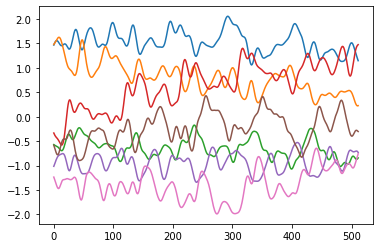

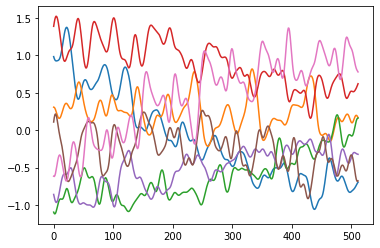

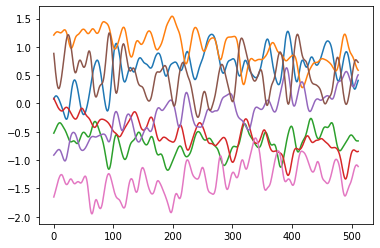

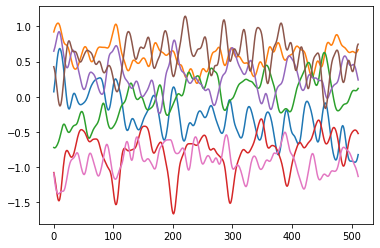

subject 17 is preprocessed


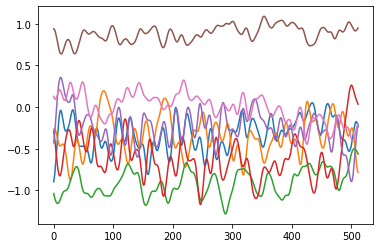

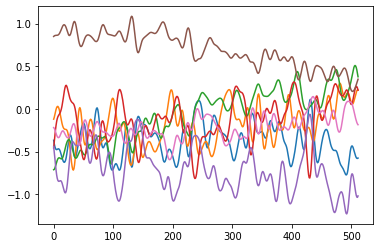

KeyboardInterrupt: 

In [27]:
## DataProcessing and model generation process
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs 

def Normalization(Epochs):
    for i in range(Epochs.shape[0]):
        for j in range(Epochs.shape[1]):
            max_val = np.max(Epochs[i,j,:])
            min_val = np.min(Epochs[i,j,:])
            
            Epochs[i,j,:] = np.subtract(Epochs[i,j,:], min_val)
            Epochs[i,j,:] = Epochs[i,j,:] / (max_val - min_val)
            
    return Epochs

# def Normalization(Epochs):
#     for i in range(Epochs.shape[1]):
#         max_val = np.max(Epochs[:,i,:])
#         min_val = np.min(Epochs[:,i,:])

#         Epochs[:,i,:] = np.subtract(Epochs[:,i,:], min_val) / (max_val - min_val)
            
#     return Epochs

def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]

def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    All_Epochs = np.concatenate((EpochsT, EpochsN))
    All_Epochs = Standardization(All_Epochs)   
    EpochsT = All_Epochs[0:EpochsT.shape[0],:,:]
    EpochsN = All_Epochs[EpochsT.shape[0]:,:,:]
    
    for i in range(7):
        plt.plot(EpochsN[0,i,:])
    plt.show()
    
    for i in range(7):
        plt.plot(EpochsN[1,i,:])
    plt.show()
    
    
#     All_Epochs = np.concatenate((EpochsT, EpochsN))
    
#     All_Epochs = Normalization(All_Epochs)
    
#     EpochsT = All_Epochs[0:EpochsT.shape[0],:,:]
#     EpochsN = All_Epochs[EpochsT.shape[0]:,:,:]

#     EpochsT = Normalization(EpochsT)
#     EpochsN = Normalization(EpochsN)
    
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch

def plotGraph(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 260
        resampleRate = 100
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))
        for i in np.arange(1,3):
            if (i==2):
                filename = filename + '_2'
            mat = hdf5storage.loadmat(filename)
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq'][0,0]
            stimsN = mat['stimsN']
            stimsT = mat['stimsT']
            sampleNum = eegData.shape[1]
            channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
            eegData = eegData[channelIndex]
            
            ## Preprocessing process
            eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, 4)
        
#             #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
            [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
            
            EpochsN_New = np.zeros((NumT, channelNum, epochSampleNum))
            NumN = NumT
            for j in range(NumN):
                EpochsN_New[j,:,:] = np.mean(EpochsN[j*5:j*5+5, :, :], axis=0)
            
#             #Convert to feature vector
            [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN_New, NumN, channelNum, epochSampleNum, 20)
#             EpochsT_Aver = resampling(EpochsT_Aver, NumT_Aver, resampleRate, channelNum) 
#             EpochsN_Aver = resampling(EpochsN_Aver, NumN_Aver, resampleRate, channelNum)
            
            
# #             #plotting graphs
#             EpochsT_Aver_all = np.mean(EpochsT, axis = 1)
#             EpochsN_Aver_all = np.mean(EpochsN, axis = 1)

#             EpochsT_Aver_Channels = np.mean(EpochsT_Aver_all, axis = 0)
#             EpochsN_Aver_Channels = np.mean(EpochsN_Aver_all, axis = 0)

#             print(EpochsT_Aver_all.shape)
#             for j in range(channelNum):
# #                 plt.plot(EpochsT_Aver_all[j])
#                 plt.plot(EpochsT[0,j,:])
#             plt.show()

#             for j in range(channelNum):
# #                 plt.plot(EpochsN_Aver_all[j])
#                 plt.plot(EpochsN[0,j,:])
#             plt.show()

#             plt.plot(EpochsT_Aver_Channels)
#             plt.show()
#             plt.plot(EpochsN_Aver_Channels)
#             plt.show()
            
    
    
#             target[130*(i-1):130*i,:,:] = EpochsT_Aver_all
#             nontarget[130*(i-1):130*i,:,:] = EpochsN_Aver_all
        
#         return [target, nontarget]


def main():
    root = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\P300Biosemi55\\S'

    for i in np.arange(1,56):
        if(i<10):
            filename = root + '0' + str(i)
        else:
            filename = root + str(i)
        plotGraph(filename)
        print("subject {0} is preprocessed".format(str(i)))

    
    
    
if __name__ == "__main__":
    main()

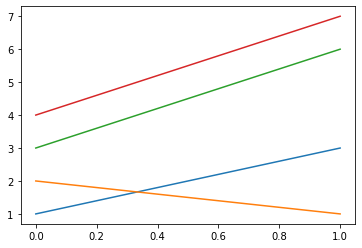

In [11]:
import matplotlib.pyplot as plt

a = [[1,2,3,4],[3,1,6,7]]
plt.plot(a)
plt.show()
